In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import harmonypy as hm

from matplotlib import rcParams
from pathlib import Path
from tqdm import tqdm

import iSp3D as MODEL
from iSp3D import Func
from iSp3D import iSpaNet
from iSp3D.Classifier import iSpaNetClassifier
from iSp3D.Utils import align_spatial_slices
from iSp3D.Attribution import compute_and_summary_by_cluster
from iSp3D.Metrics import compute_ARI, compute_NMI, compute_HOM, compute_COM, compute_PAS, compute_CHAOS
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'


def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping


def inverse_pca_transform(pca, recon_pca_data, adata):
    recon_scaled = pca.inverse_transform(recon_pca_data)
    recon_log1p = recon_scaled * adata.var['std'].values + adata.var['mean'].values
    recon_normalized = np.exp(recon_log1p) - 1 
    return recon_normalized


def get_data(proj_list, config):
    global graph_dict
    data_root = Path(r'C:\Code\Data\SlideSeqV2_Stereoseq_MOB')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_h5ad(os.path.join(r"C:\Code\Data\SlideSeqV2_Stereoseq_MOB\MOB_" + proj_name + ".h5ad"))
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        graph_dict_tmp = Func.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = Func.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata.obsm['X_original'] = adata.X.copy()

    pca = PCA(n_components=200, random_state=42)
    adata_X = pca.fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict, pca

In [2]:
with open(r'C:\Code\iSpa3D\Config\Config_MOB.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [3]:
proj_list = ['Slide-seqV2', 'Stereo-seq']
adata, graph_dict, pca = get_data(proj_list, config['data'])

100%|██████████| 2/2 [01:02<00:00, 31.20s/it]


In [4]:
num_cluster = 10
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [5]:
method = 'mclust'

In [6]:
net.train()

Epoch 395 total loss=3.043 recon loss=0.899 tri loss=0.000 disc loss=0.338 cluster loss=2.946:  50%|████▉     | 398/800 [00:19<00:17, 22.58it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 445 total loss=3.394 recon loss=0.940 tri loss=0.467 disc loss=0.417 cluster loss=2.881:  56%|█████▋    | 450/800 [00:51<00:26, 13.27it/s]

fitting ...
  |======================================================================| 100%


Epoch 495 total loss=3.211 recon loss=0.934 tri loss=0.348 disc loss=0.356 cluster loss=2.813:  62%|██████▎   | 500/800 [01:51<00:23, 13.03it/s]

fitting ...
  |======================================================================| 100%


Epoch 545 total loss=3.128 recon loss=0.911 tri loss=0.309 disc loss=0.338 cluster loss=2.774:  69%|██████▊   | 549/800 [02:51<00:20, 12.52it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=3.093 recon loss=0.911 tri loss=0.296 disc loss=0.332 cluster loss=2.747:  75%|███████▌  | 600/800 [03:44<00:14, 13.57it/s]

fitting ...
  |===================================                                   |  50%

Epoch 595 total loss=3.093 recon loss=0.911 tri loss=0.296 disc loss=0.332 cluster loss=2.747:  75%|███████▌  | 600/800 [03:59<00:14, 13.57it/s]

  |======================================================================| 100%


Epoch 645 total loss=3.085 recon loss=0.906 tri loss=0.291 disc loss=0.334 cluster loss=2.743:  81%|████████▏ | 650/800 [05:20<00:16,  9.16it/s]

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=3.105 recon loss=0.903 tri loss=0.337 disc loss=0.333 cluster loss=2.731:  87%|████████▋ | 699/800 [06:14<00:09, 10.72it/s]

fitting ...
  |======================================================================| 100%


Epoch 745 total loss=3.090 recon loss=0.901 tri loss=0.320 disc loss=0.331 cluster loss=2.730:  94%|█████████▎| 749/800 [07:16<00:04, 12.33it/s]

fitting ...
  |===================================                                   |  50%

Epoch 745 total loss=3.090 recon loss=0.901 tri loss=0.320 disc loss=0.331 cluster loss=2.730:  94%|█████████▎| 749/800 [07:29<00:04, 12.33it/s]

  |======================================================================| 100%


Epoch 795 total loss=3.068 recon loss=0.895 tri loss=0.297 disc loss=0.330 cluster loss=2.727: 100%|██████████| 800/800 [08:28<00:00,  1.57it/s]


In [7]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon, adata)
adata.obsm['X_reconstructed'] = recon_original

print(adata)

AnnData object with n_obs × n_vars = 39248 × 2000
    obs: 'batch_name', 'slice_id', 'proj_name', 'batch', 'Tmp_domain'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    obsm: 'spatial', 'X_original', 'X_pca', 'latent', 'recon', 'X_reconstructed'
    layers: 'count'


In [8]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


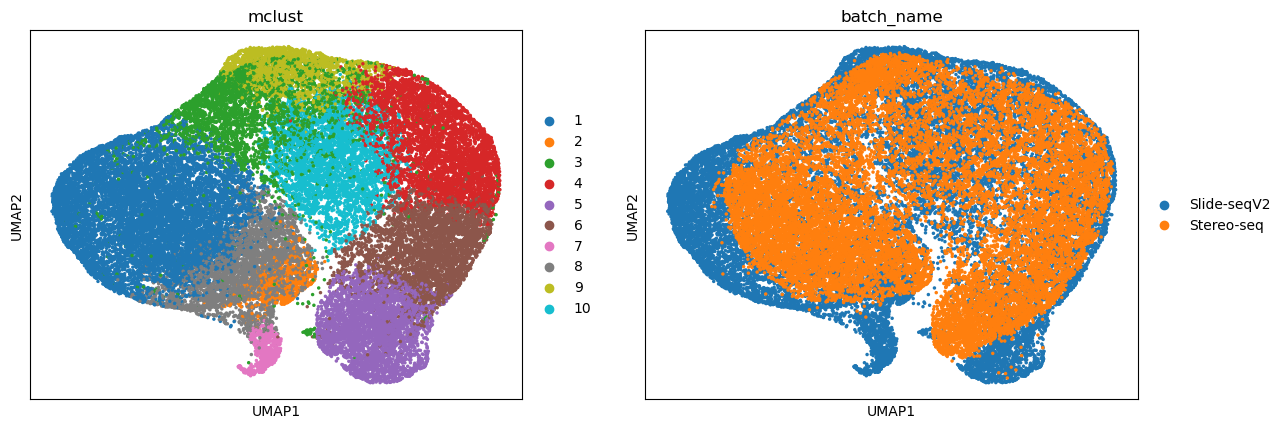

In [9]:
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
fig = sc.pl.umap(adata,color=['mclust', 'batch_name'],size=25,show=False,return_fig=True)
fig.show()
# fig.savefig("umap_mclust_batch.pdf", bbox_inches="tight")

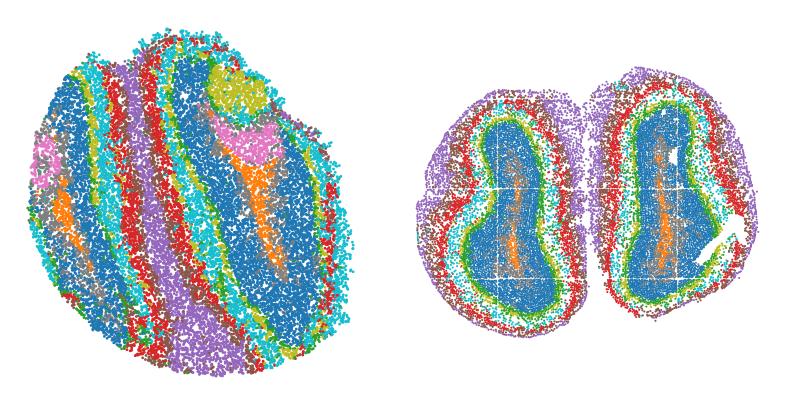

In [10]:
import matplotlib.pyplot as plt
spot_size = 35
title_size = 12
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx, name in enumerate(proj_list):
    sub_adata = adata[adata.obs['batch_name'] == name]
    _sc_ = sc.pl.spatial(sub_adata, img_key=None, color=['mclust'], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                         spot_size=spot_size)
plt.tight_layout()
# plt.savefig('spatial_mclust.pdf', bbox_inches='tight', dpi=300)
plt.show()

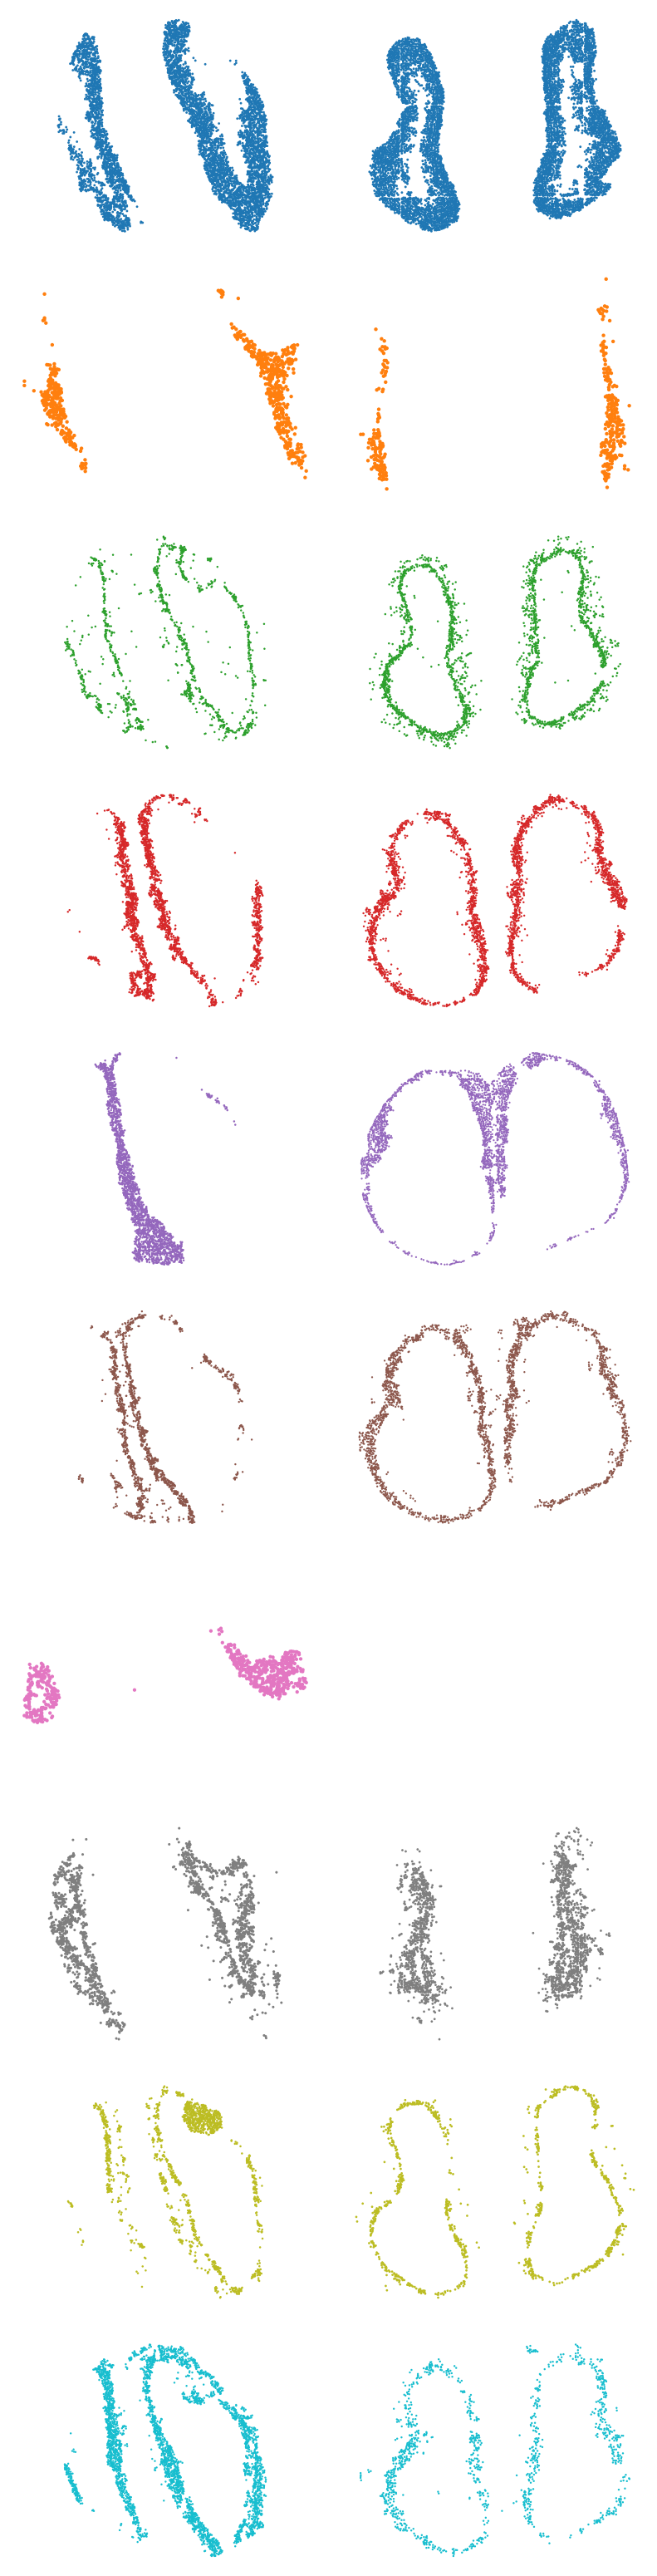

In [11]:
spot_size = 40
title_size = 12
fig, ax = plt.subplots(10, 2, figsize=(10, 40), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
kkk = 0

for domain in [1,2,3,4,5,6,7,8,9,10]:
    for idx, name in enumerate(proj_list):
        sub_adata = adata[adata.obs['batch_name'] == name]
        sub_adata = sub_adata[sub_adata.obs['mclust']==domain]
        _sc_ = sc.pl.spatial(sub_adata, img_key=None, color=['mclust'], title=[''],
                          legend_loc=None, legend_fontsize=12, show=False, ax=ax[kkk, idx], frameon=False,
                          spot_size=spot_size)
    kkk += 1
plt.show()

In [12]:
with open('C:\\Code\\iSpa3D\\Config\\classifier_config.yaml', 'r', encoding='utf-8') as f:
    classifier_config = yaml.load(f.read(), Loader=yaml.FullLoader)
    
cluster_labels_original = adata.obs['mclust'].values.astype(int)
 
unique_labels = np.unique(cluster_labels_original)
label_mapping = {old: new for new, old in enumerate(sorted(unique_labels))}
cluster_labels_for_training = np.array([label_mapping[label] for label in cluster_labels_original])


classifier = iSpaNetClassifier(in_features=config['model']['latent_dim'], n_classes=len(unique_labels), config=classifier_config, device=device)
classifier.prepare_data(g3net_model=net, adata=adata, target_labels=cluster_labels_for_training)
classifier.train(epochs=classifier.max_epochs, verbose=True, early_stop_patience=50)

Epoch [ 10/300] Train Loss: 0.7971, Train Acc: 0.6949 | Val Loss: 0.6153, Val Acc: 0.7757
Epoch [ 20/300] Train Loss: 0.7812, Train Acc: 0.7025 | Val Loss: 0.6219, Val Acc: 0.7755
Epoch [ 30/300] Train Loss: 0.7788, Train Acc: 0.7054 | Val Loss: 0.6286, Val Acc: 0.7686
Epoch [ 40/300] Train Loss: 0.7693, Train Acc: 0.7117 | Val Loss: 0.6164, Val Acc: 0.7750
Epoch [ 50/300] Train Loss: 0.7728, Train Acc: 0.7039 | Val Loss: 0.6154, Val Acc: 0.7791
Epoch [ 60/300] Train Loss: 0.7499, Train Acc: 0.7129 | Val Loss: 0.6113, Val Acc: 0.7791
Epoch [ 70/300] Train Loss: 0.7622, Train Acc: 0.7123 | Val Loss: 0.6091, Val Acc: 0.7892

Early stopping at epoch 72


In [ ]:
res_df = compute_and_summary_by_cluster(
    net=net,
    cluster_key='mclust',
    classifier=classifier,
    top_k=100,
    pca=pca, 
    target_clusters=None, 
    spatial_radius=100,
)

Computing attributions for 10 clusters...


Cluster attribution:   0%|          | 0/10 [00:00<?, ?it/s]

Cluster 1: neighbors = ['3', '8', '9', '2']


Cluster attribution:  10%|█         | 1/10 [02:31<22:45, 151.70s/it]

Cluster 10: neighbors = ['3', '4', '9']


Cluster attribution:  20%|██        | 2/10 [05:03<20:15, 151.93s/it]

Cluster 2: neighbors = ['8']


Cluster attribution:  30%|███       | 3/10 [05:57<12:28, 106.92s/it]

Cluster 3: neighbors = ['1', '9', '10']


Cluster attribution:  40%|████      | 4/10 [08:29<12:29, 124.99s/it]

Cluster 4: neighbors = ['10', '6', '3']


Cluster attribution:  50%|█████     | 5/10 [11:02<11:15, 135.09s/it]

Cluster 5: neighbors = ['6']


Cluster attribution:  60%|██████    | 6/10 [11:59<07:13, 108.37s/it]

Cluster 6: neighbors = ['4', '5']


Cluster attribution:  70%|███████   | 7/10 [13:46<05:23, 107.83s/it]

Cluster 7: neighbors = ['8', '2']


Cluster attribution:  80%|████████  | 8/10 [15:27<03:31, 105.71s/it]

Cluster 8: neighbors = ['1', '2']


Cluster attribution:  90%|█████████ | 9/10 [17:13<01:45, 105.86s/it]

Cluster 9: neighbors = ['3']


Cluster attribution: 100%|██████████| 10/10 [18:09<00:00, 108.95s/it]


In [ ]:
final_dfs, top_dict, per_method_dfs = res_df

for cluster_label in sorted(final_dfs.keys()):
    obj = final_dfs[cluster_label]
    
    if isinstance(obj, pd.DataFrame):
        sort_col = 'final_score' if 'final_score' in obj.columns else ('diff' if 'diff' in obj.columns else None)
        if sort_col:
            genes = obj.sort_values(sort_col, ascending=False).head(20).index.tolist()
        else:
            genes = obj.index[:20].tolist()
    else:
        genes = list(obj)[:20]
    
    print(f"Cluster {cluster_label}: {genes}")


Cluster 1: ['Slc17a7', 'Cdhr1', 'Spp1', 'Shisa3', 'Stmn2', 'Reln', 'Rab3b', 'Ptn', 'Slc20a1', 'Ptprd', 'Ms4a15', 'Tbx21', 'Doc2g', 'Uchl1', 'Tshz2', 'Chst15', 'Sv2b', 'Nrn1', 'Tmem163', 'Gabra1']
Cluster 10: ['Pcp4', 'Camk2n1', 'Pbx3', 'Pcp4l1', 'Nrxn3', 'Penk', 'Pnmal2', 'Malat1', 'Kcnb2', 'Plcb1', 'Nrgn', 'Cpne4', 'Tuba1a', 'Auts2', 'Ablim3', 'Atp1b1', 'Rbfox1', 'Meg3', 'Cpne6', 'Dpp6']
Cluster 2: ['Islr2', 'Sox11', 'Dpysl3', 'Igfbpl1', 'Stmn2', 'Tubb2b', 'Nnat', 'Mex3a', 'Gng2', 'Gpc2', 'Vcan', 'Fxyd6', 'Ccnd2', 'Zfp704', 'Sox4', '1500015O10Rik', 'Nrep', 'Dcx', 'Crabp1', 'Miat']
Cluster 3: ['Egr4', 'Kcnh2', 'Kcnb2', 'Kctd17', 'Chdh', 'Adnp', 'Scgn', 'Kank3', 'Tenm2', 'Mamld1', 'Kcnq5', 'Npas4', 'Gpr27', 'Gm20716', 'Etl4', 'Gm20458', 'Cish', 'Gm37459', 'Chsy3', 'Il1rapl1']
Cluster 4: ['Cdhr1', 'Slc17a7', 'Ptprd', 'Spp1', 'Shisa3', 'Reln', 'Gabra1', 'Rab3b', 'Ms4a15', 'Sv2b', 'Doc2g', 'Tbx21', 'Lrrc55', 'Plcxd2', 'Tmem163', 'Nrn1', 'Nmb', 'Cck', 'Chst15', 'Slc20a1']
Cluster 5: ['Igf2'

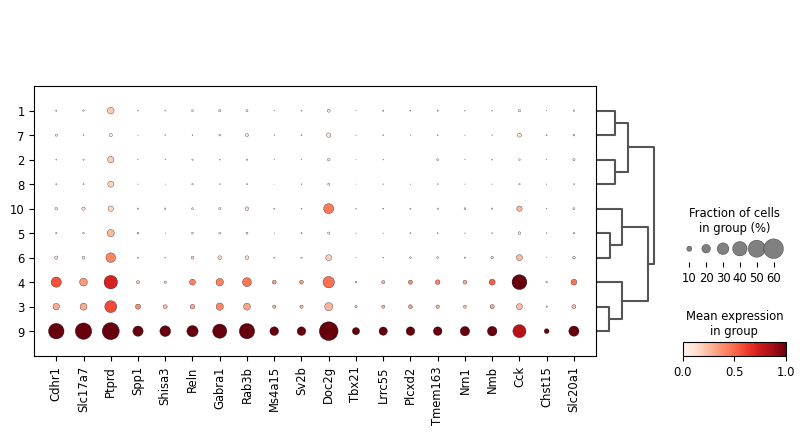

In [42]:
adata.obs['re_mclust'] = adata.obs['mclust'].astype(str)
dg =['Cdhr1', 'Slc17a7', 'Ptprd', 'Spp1', 'Shisa3', 'Reln', 'Gabra1', 'Rab3b', 'Ms4a15', 'Sv2b', 'Doc2g', 'Tbx21', 'Lrrc55', 'Plcxd2', 'Tmem163', 'Nrn1', 'Nmb', 'Cck', 'Chst15', 'Slc20a1']
sc.pl.dotplot(adata, dg, groupby='re_mclust', dendrogram=True, swap_axes=False, standard_scale='var')